In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import joblib
import os

# Set visualization style for plots
sns.set_style("whitegrid")

# Load Anonymized Data
print("Step 1: Loading anonymized data...")
DATA_DIR = '../data'
CALLS_PATH = os.path.join(DATA_DIR, 'call_created_anonymized.csv')
CENSUS_PATH = os.path.join(DATA_DIR, 'census_check_anonymized.csv')

try:
    calls_df = pd.read_csv(CALLS_PATH, parse_dates=['original_timestamp'], low_memory=False)
    census_df = pd.read_csv(CENSUS_PATH, parse_dates=['original_timestamp'], low_memory=False)
    print("Anonymized data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure your anonymized CSV files are in the 'data' directory.")

# Display initial data shapes and head
print(f"Calls data shape: {calls_df.shape}")
print(f"Census data shape: {census_df.shape}")
calls_df.head()

Step 1: Loading anonymized data...
Anonymized data loaded successfully.
Calls data shape: (223080, 28)
Census data shape: (158723, 20)


,id,received_at,event,organization_name,uuid_ts,context_library_name,timestamp,call_id,call_type,room_id,...,subscribers_for_call,active_subscriptions,created_from,generated_patient_id,hospital_name,patient_oriented,patient_present,care_provider_name,updated_from,dispatch_message
0,0000239e-cf53-45eb-831b-63b821f5b506,2025-04-27 19:43:14.5+00,call_created,Unit 1,2025-04-28 06:12:39+00,analytics-ruby,2025-04-27 19:43:14.499+00,160491,Check Glucose,332,...,6.0,1.0,hub,277ac8b9-5f4d-4b72-9793-cef2525631f3,Seattle Grace,True,True,NaN,NaN,NaN
1,00005aaf-5d85-44e9-bd47-63c0d86fc13b,2025-08-21 15:37:52.978+00,call_created,Unit 7,2025-08-21 20:12:51+00,analytics-ruby,2025-08-21 15:37:52.977+00,235653,Soda,433,...,3.0,1.0,patient,41010243-3035-4d66-a5f4-53e26784cbe4,Seattle Grace,False,True,Not Set,NaN,NaN
2,000073f0-1218-4e91-be78-ff1eedd2229c,2025-02-08 05:30:51.72+00,call_created,Unit 1,2025-02-08 06:12:50+00,analytics-ruby,2025-02-08 05:30:51.72+00,124594,Beeping Machine,357,...,2.0,1.0,patient,c440d295-eab4-4c02-9c6a-869e9c22418b,Seattle Grace,True,True,NaN,NaN,NaN
3,00009930-daf2-409a-a04a-4137df01efaf,2025-04-06 14:26:49.249+00,call_created,Unit 1,2025-04-06 18:12:49+00,analytics-ruby,2025-04-06 14:26:49.248+00,149442,Linen change,351,...,3.0,2.0,hub,218c6cda-7616-4c1d-8077-c0c2451c07d5,Seattle Grace,True,True,NaN,NaN,NaN
4,0001172e-138f-4cd7-8f1e-2af97e641f3c,2025-07-21 21:19:12.762+00,call_created,Unit 8,2025-07-22 08:12:37+00,analytics-ruby,2025-07-21 21:19:12.761+00,213032,1:1 Feeds,401,...,2.0,2.0,hub,3080dc2b-5f23-4fc3-8048-e10a71577708,Seattle Grace,False,True,Not Set,NaN,NaN


In [2]:
# 2. Process and Categorize Call Data
print("\nStep 2: Processing and categorizing call data...")

# --- Filter out 'Unknown' hospital data ---
initial_rows = len(calls_df)
print(f"Rows before filtering 'Unknown' hospital: {initial_rows}")
calls_df = calls_df[calls_df['hospital_name'] != 'Unknown'].copy()
print(f"Removed {initial_rows - len(calls_df)} rows from 'Unknown' hospital.")
print(f"Rows remaining: {len(calls_df)}")


# Select necessary columns for the model and drop rows with missing essential data
calls_df = calls_df[['original_timestamp', 'organization_id', 'call_type']].copy()
calls_df.dropna(subset=['original_timestamp', 'organization_id', 'call_type'], inplace=True)
calls_df['call_type'] = calls_df['call_type'].astype(str)

# categorize_call function (based on 128 unique types)
def categorize_call(call_type):
    """Maps a specific call_type string to a broader category based on actual data."""
    call_type_lower = call_type.lower()
    
    # Category 1: Clinical
    clinical_keywords = [
        'pain', 'nausea', 'medication', 'glucose', 'sugar', 'insulin',
        'diabetic', 'vomiting', 'beeping', 'dressing', 'ekg', 'tums',
        'purewick', 'chg bath', 'charge nurse'
    ]
    if any(keyword in call_type_lower for keyword in clinical_keywords):
        return 'Clinical'
        
    # Category 2: Mobility
    mobility_keywords = [
        'restroom', 'walk', 'bed', 'reposition', 'commode', 'bedpan',
        'urinal', 'shower', 'bath', 'bathroom'
    ]
    if any(keyword in call_type_lower for keyword in mobility_keywords):
        return 'Mobility'
        
    # Category 3: Basic Need / Food & Drink
    basic_need_keywords = [
        'thirsty', 'hungry', 'water', 'meal', 'food', 'snack', 'juice',
        'coffee', 'tea', 'milk', 'soda', 'ice', 'jello', 'pudding',
        'yogurt', 'cracker', 'cheese', 'ensure', 'fruit', 'sauce',
        'peanut butter', 'cheerios', 'popsicle', 'tray'
    ]
    if any(keyword in call_type_lower for keyword in basic_need_keywords):
        return 'Basic Need'

    # Category 4: Housekeeping & Room Environment
    housekeeping_keywords = [
        'housekeeping', 'linen', 'towel', 'soap', 'floor', 'trash', 'paper',
        'sanitizer', 'clean-up', 'pillowcase', 'sheets', 'blanket',
        'gown', 'lights on / off', 'too hot', 'too cold', 'heat pack'
    ]
    if any(keyword in call_type_lower for keyword in housekeeping_keywords):
        return 'Housekeeping'

        
    # Category 5: Other / Administrative
    else:
        return 'Other'

# Apply the function to create a new 'call_category' column
calls_df['call_category'] = calls_df['call_type'].apply(categorize_call)
print("Call categories created.")
calls_df.head()


Step 2: Processing and categorizing call data...
Rows before filtering 'Unknown' hospital: 223080
Removed 51814 rows from 'Unknown' hospital.
Rows remaining: 171266
Call categories created.


,original_timestamp,organization_id,call_type,call_category
0,2025-04-27 19:43:14.420423+00:00,78,Check Glucose,Clinical
1,2025-08-21 15:37:52.924017+00:00,82,Soda,Basic Need
2,2025-02-08 05:30:51.486907+00:00,78,Beeping Machine,Clinical
3,2025-04-06 14:26:49.193057+00:00,78,Linen change,Housekeeping
4,2025-07-21 21:19:12.698817+00:00,77,1:1 Feeds,Other


In [3]:
# 3. Aggregate, Pivot, and Merge
print("\nStep 3: Aggregating calls and merging with census data...")

hourly_calls = calls_df.copy()
hourly_calls['timestamp_hour'] = hourly_calls['original_timestamp'].dt.floor('h')

# Group by organization, the new hour column, and the category
hourly_calls_pivoted = hourly_calls.groupby(['organization_id', 'timestamp_hour', 'call_category']) \
                                   .size() \
                                   .unstack(fill_value=0) \
                                   .reset_index()

# Prepare census data for merging
census_cols = ['original_timestamp', 'organization_id', 'rooms_with_patients']
census_df_clean = census_df[census_cols].copy()
census_df_clean.dropna(inplace=True)
census_df_clean.drop_duplicates(subset=['organization_id', 'original_timestamp'], keep='last', inplace=True)

print("Preparing data for merge...")

# Ensure consistent data types
hourly_calls_pivoted['organization_id'] = hourly_calls_pivoted['organization_id'].astype(int)
census_df_clean['organization_id'] = census_df_clean['organization_id'].astype(int)

# Round timestamps to nearest hour for exact matching
hourly_calls_pivoted['timestamp_rounded'] = hourly_calls_pivoted['timestamp_hour'].dt.round('h')
census_df_clean['timestamp_rounded'] = census_df_clean['original_timestamp'].dt.round('h')

# Perform the merge
final_df = pd.merge(
    hourly_calls_pivoted,
    census_df_clean[['organization_id', 'timestamp_rounded', 'rooms_with_patients']],
    on=['organization_id', 'timestamp_rounded'],
    how='left'
)

# Clean up the merged dataframe
final_df.drop(columns=['timestamp_rounded'], inplace=True)
final_df.dropna(subset=['rooms_with_patients'], inplace=True)

# Filter out records where census is zero
print(f"Data merged successfully. Shape before cleaning: {final_df.shape}")
initial_rows = len(final_df)
final_df = final_df[final_df['rooms_with_patients'] > 0].copy()

print(f"Final dataframe shape after cleaning: {final_df.shape}")
final_df.head()


Step 3: Aggregating calls and merging with census data...
Preparing data for merge...
Data merged successfully. Shape before cleaning: (56964, 8)
Final dataframe shape after cleaning: (56958, 8)


,organization_id,timestamp_hour,Basic Need,Clinical,Housekeeping,Mobility,Other,rooms_with_patients
0,35,2024-05-08 20:00:00+00:00,0,1,0,0,0,35.0
1,35,2024-05-08 21:00:00+00:00,0,0,0,1,0,34.0
2,35,2024-05-08 23:00:00+00:00,1,1,0,0,0,29.0
3,35,2024-05-09 01:00:00+00:00,0,0,0,1,0,30.0
4,35,2024-05-09 03:00:00+00:00,0,1,0,0,3,32.0



Step 4: Removing outliers and generating visualizations...
Identifying and removing outlier days (total calls > 1000)...
No days found with over 1000 calls. No outliers removed.
Generated Visualization 1: Average Calls by Category per Day of the Week.


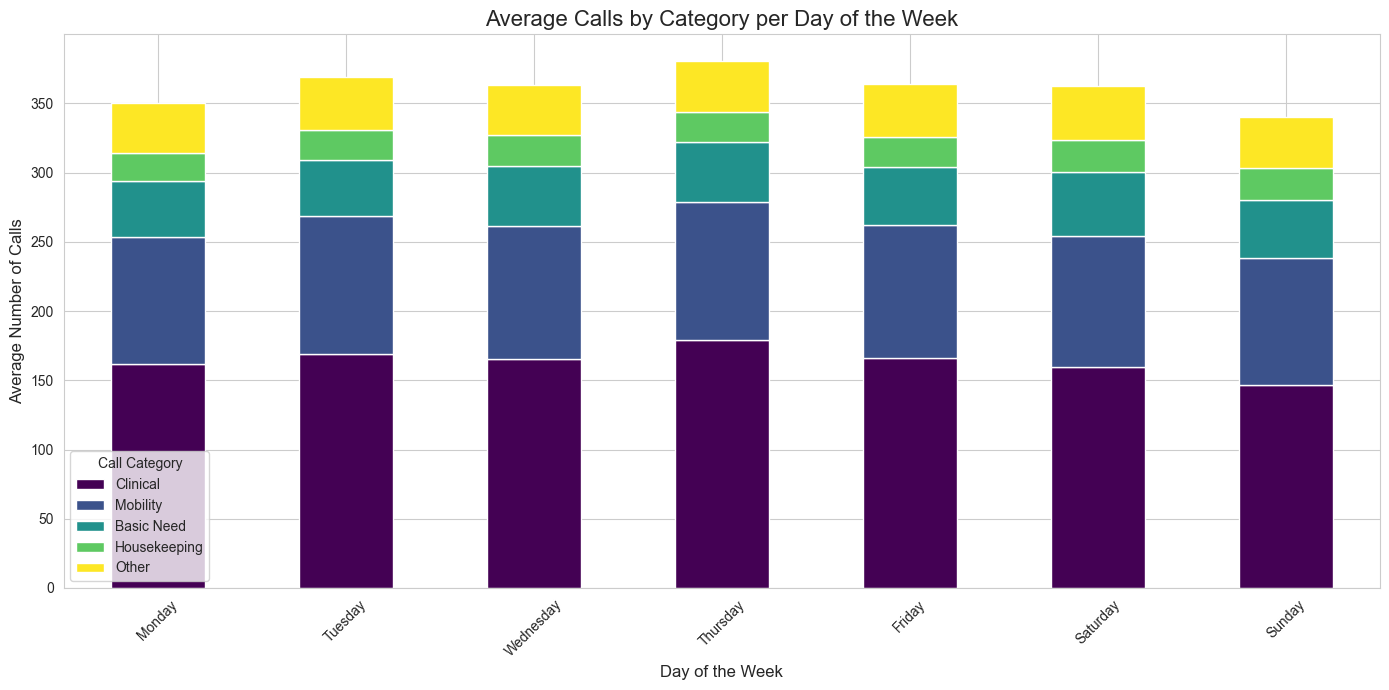

Visualization 2: Average Calls by Hour.


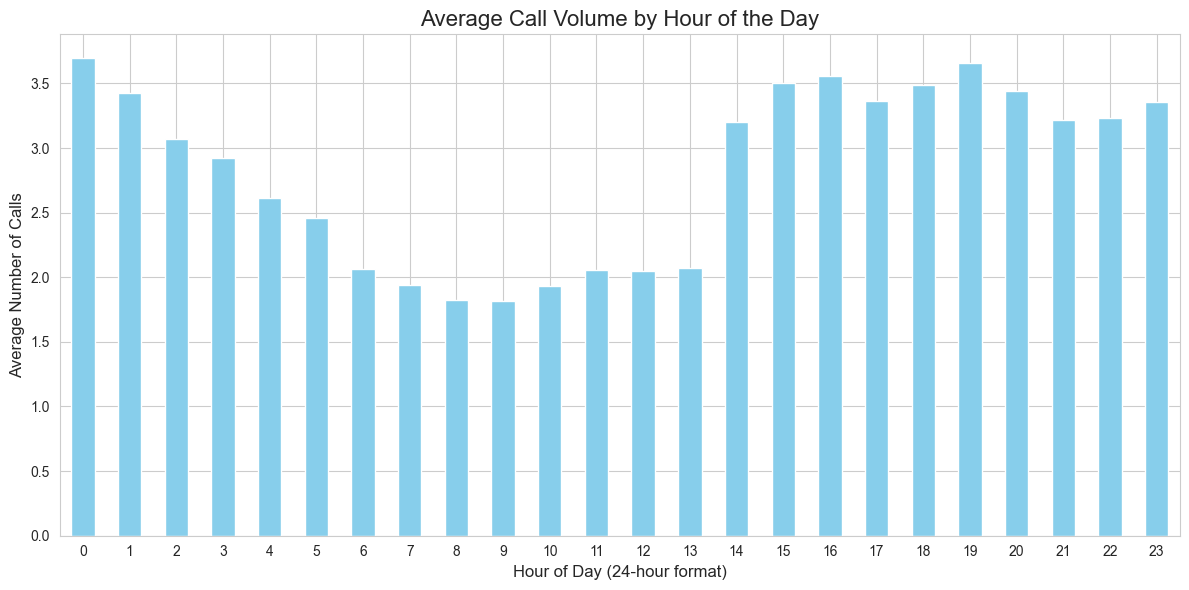

Visualization 3: Call Volume vs. Patient Census.


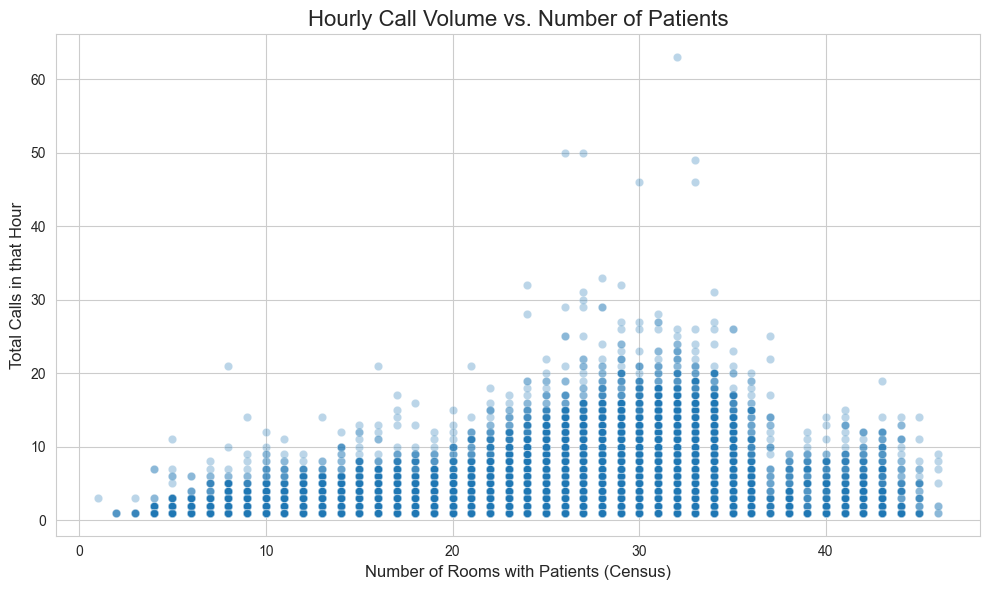

In [4]:
# 4. Outlier Removal and Visualizations
print("\nStep 4: Removing outliers and generating visualizations...")

# Define the final list of categories
call_categories = ['Clinical', 'Mobility', 'Basic Need', 'Housekeeping', 'Other']

# Ensure all expected category columns exist in the DataFrame, filling with 0 if not
for col in call_categories:
    if col not in final_df.columns:
        final_df[col] = 0

# Create a 'total_calls' column for analysis
final_df['total_calls'] = final_df[call_categories].sum(axis=1)

# RE-ADD Outlier Removal Step
print("Identifying and removing outlier days (total calls > 1000)...")
initial_rows = len(final_df)

# Create a temporary 'date' column for daily grouping
final_df['date'] = final_df['timestamp_hour'].dt.date

# Calculate total calls per organization per day
daily_counts = final_df.groupby(['organization_id', 'date'])['total_calls'].sum().reset_index()

# Identify the outlier days
outlier_days = daily_counts[daily_counts['total_calls'] > 1000]

if not outlier_days.empty:
    print("Found the following outlier days to remove:")
    print(outlier_days)
    
    # Create a multi-index of the outlier orgs and dates to filter them out
    outlier_index = pd.MultiIndex.from_frame(outlier_days[['organization_id', 'date']])
    
    # Create a boolean mask to identify rows in the main dataframe that are part of an outlier day
    is_outlier = pd.MultiIndex.from_frame(final_df[['organization_id', 'date']]).isin(outlier_index)
    
    # Filter the main dataframe by keeping rows that are NOT outliers
    final_df = final_df[~is_outlier].copy()
    
    print(f"Removed {initial_rows - len(final_df)} hourly rows corresponding to outlier days.")
else:
    print("No days found with over 1000 calls. No outliers removed.")

# Drop the temporary 'date' column
final_df.drop(columns=['date'], inplace=True)


# Continue with visualizations using the cleaned final_df
final_df['hour_of_day'] = final_df['timestamp_hour'].dt.hour
final_df['day_of_week'] = final_df['timestamp_hour'].dt.dayofweek # Monday=0, Sunday=6


# Visualization 1: Average Calls by Category per Day of the Week
print("Generated Visualization 1: Average Calls by Category per Day of the Week.")

daily_category_totals = final_df.groupby('day_of_week')[call_categories].sum()
unique_day_counts = final_df.groupby('day_of_week')['timestamp_hour'].apply(lambda x: x.dt.date.nunique())
daily_category_avg = daily_category_totals.div(unique_day_counts, axis=0)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_category_avg.index = daily_category_avg.index.map(lambda x: day_names[x])
daily_category_avg.plot(kind='bar', stacked=True, figsize=(14, 7),
                        colormap='viridis')

plt.title('Average Calls by Category per Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Number of Calls', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Call Category')
plt.tight_layout()
plt.show()


# Visualization 2: Average Calls by Hour of Day
print("Visualization 2: Average Calls by Hour.")
hourly_avg = final_df.groupby('hour_of_day')['total_calls'].mean()
plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Call Volume by Hour of the Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Average Number of Calls', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Visualization 3: Relationship between Patient Census and Call Volume
print("Visualization 3: Call Volume vs. Patient Census.")
plt.figure(figsize=(10, 6))
final_df['rooms_with_patients'] = pd.to_numeric(final_df['rooms_with_patients'])
sns.scatterplot(data=final_df, x='rooms_with_patients', y='total_calls', alpha=0.3)
plt.title('Hourly Call Volume vs. Number of Patients', fontsize=16)
plt.xlabel('Number of Rooms with Patients (Census)', fontsize=12)
plt.ylabel('Total Calls in that Hour', fontsize=12)
plt.tight_layout()
plt.show()

In [5]:
# 5. Feature Engineering
print("\nStep 5: Engineering features for the model...")

# Add any additional time-based features
final_df['day_of_week'] = final_df['timestamp_hour'].dt.dayofweek # Monday=0, Sunday=6
final_df['month'] = final_df['timestamp_hour'].dt.month

# Define our features (X) and targets (y)
features = [
    'rooms_with_patients',
    'hour_of_day',
    'day_of_week',
    'month'
]

# Use the final list of categories as our targets
targets = ['Clinical', 'Mobility', 'Basic Need', 'Housekeeping', 'Other']

# Ensure the target columns exist and are numeric, fill NaNs just in case
for col in targets:
    if col not in final_df.columns:
        final_df[col] = 0
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce').fillna(0)

X = final_df[features]
y = final_df[targets]

print("Features (X) and Targets (y) created.")
print("Features used for model:", features)
X.head()


Step 5: Engineering features for the model...
Features (X) and Targets (y) created.
Features used for model: ['rooms_with_patients', 'hour_of_day', 'day_of_week', 'month']


,rooms_with_patients,hour_of_day,day_of_week,month
0,35.0,20,2,5
1,34.0,21,2,5
2,29.0,23,2,5
3,30.0,1,3,5
4,32.0,3,3,5


In [6]:
# 6. Model Training and Evaluation
print("\nStep 6: Training and evaluating the model...")

# Sort by time before splitting to ensure chronological order 
final_df.sort_values('timestamp_hour', inplace=True)
X = final_df[features]
y = final_df[targets]

# Split data chronologically (80% train, 20% test)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=5)
model.fit(X_train, y_train)
print("Model training complete.")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model and print accuracy metrics
print("\n--- Model Evaluation (Accuracy Metrics) ---")
y_pred_df = pd.DataFrame(y_pred, columns=targets)

for category in targets:
    mae = mean_absolute_error(y_test[category], y_pred_df[category])
    r2 = r2_score(y_test[category], y_pred_df[category])
    print(f"\nCategory: {category}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f} calls")
    print(f"  R-squared (R²): {r2:.2f}")

# Overall performance for total calls
total_mae = mean_absolute_error(y_test.sum(axis=1), y_pred.sum(axis=1))
print(f"\nOverall MAE for Total Calls: {total_mae:.2f} calls")


Step 6: Training and evaluating the model...
Training set size: 45566 rows
Testing set size: 11392 rows
Model training complete.

--- Model Evaluation (Accuracy Metrics) ---

Category: Clinical
  Mean Absolute Error (MAE): 1.17 calls
  R-squared (R²): -0.01

Category: Mobility
  Mean Absolute Error (MAE): 0.98 calls
  R-squared (R²): -0.10

Category: Basic Need
  Mean Absolute Error (MAE): 0.57 calls
  R-squared (R²): -0.10

Category: Housekeeping
  Mean Absolute Error (MAE): 0.31 calls
  R-squared (R²): -0.06

Category: Other
  Mean Absolute Error (MAE): 0.52 calls
  R-squared (R²): -0.08

Overall MAE for Total Calls: 2.36 calls


In [7]:

# 7. Save Model Artifacts
print("\nStep 7: Saving model and feature columns...")

# Define the paths to save the files in the new 'models' directory
MODELS_DIR = '../models'
if not os.path.exists(MODELS_DIR):
    os.makedirs(MODELS_DIR)

model_path = os.path.join(MODELS_DIR, 'call_forecasting_model.pkl')
columns_path = os.path.join(MODELS_DIR, 'model_feature_columns.pkl')

# Save the trained model
joblib.dump(model, model_path)

# Save the list of feature columns
joblib.dump(features, columns_path)

print(f"Model saved to: {model_path}")
print(f"Feature columns saved to: {columns_path}")


Step 7: Saving model and feature columns...
Model saved to: ../models/call_forecasting_model.pkl
Feature columns saved to: ../models/model_feature_columns.pkl
